# BBC News Classification Project

This project is a part of an older Kaggle Competition that can be found [here](https://www.kaggle.com/c/learn-ai-bbc/overview). The objective is to build a model that can predict the category of an article given the article text. We have been provided both training text data, containing the text of 2000+ articles along with their category label. In this notebook I will: 
1. Perform EDA to get a better understanding of the data
2. Perform any necessary data cleaning to prep the data for model building
3. Build a model using an unsupervised approach - making use of matrix factorization 
4. Build a model using a supervised approach - making use of K-nearest-neighbors


# Step 0: Loading Kaggle data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
# Other Relevant Imports
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import itertools
from typing import Optional

from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.sparse import csr_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [3]:
# Save data to variables we can access later in the notebook
train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
sample = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

# Step 1: Exploratory Data Analysis (EDA) & Extracting Word Features & Data Preparation

Before getting started I want to get a better idea about what data we have to work with. I'll start by taking a look at the test and training data - see how many points and attributes there are for each and display the first few rows to see what the data looks like. 

In [4]:
print(f"Training Data {train.shape}")
print(f'Training Data Attributes: {list(train.columns)}')
print(f'\nTraining Data Types: {train.dtypes}\n')
train.head()

Training Data (1490, 3)
Training Data Attributes: ['ArticleId', 'Text', 'Category']

Training Data Types: ArticleId     int64
Text         object
Category     object
dtype: object



,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
print(f"Test Data {test.shape}")
print(f'Test Data Attributes: {list(test.columns)}')
print(f'Test Data Types: {test.dtypes}\n')
test.head()

Test Data (735, 2)
Test Data Attributes: ['ArticleId', 'Text']
Test Data Types: ArticleId     int64
Text         object
dtype: object



,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


Next let's take a look at the categories we're working with:

Category
sport            0.232215
business         0.225503
politics         0.183893
entertainment    0.183221
tech             0.175168
Name: proportion, dtype: float64


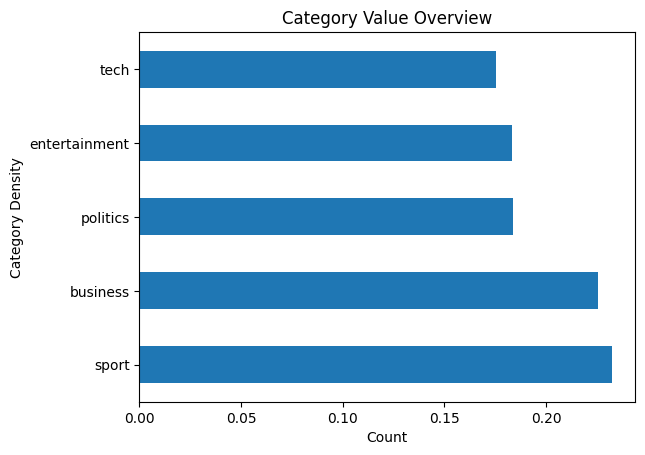

In [6]:
def column_breakdown(data: pd.DataFrame, column_name: str, normalized: bool = True) -> None: 
    """
    Helper to show get a breakdown of count/density of values seen in a given column
    """
    category_breakdown = data[column_name].value_counts(normalize=normalized)
    print(category_breakdown)
    category_breakdown.plot(kind='barh')
    y_lab = f'{column_name} Density' if normalized else f'{column_name} Counts'
    plt.ylabel(f'{column_name} Density')
    plt.xlabel('Count')
    plt.title(f'{column_name} Value Overview')
    plt.show()
    
column_breakdown(train,'Category')

We have 5 categories to work with: tech, entertainment, politics, business, sport. It looks like sport and buisness make up slightly more of the articles than the other three categories. Business and sport are close to 23% each while the others are closer to 18%. Now lets see if any of the articles are duplicates.

Duplicates found: 50
Category
tech             0.54
entertainment    0.20
politics         0.16
sport            0.08
business         0.02
Name: proportion, dtype: float64


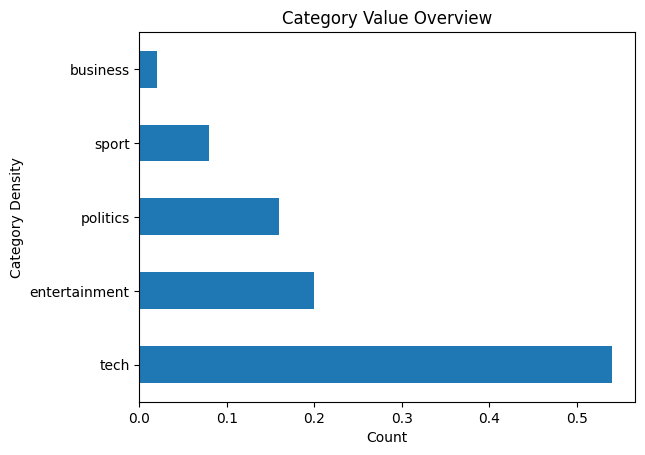

In [7]:
# Check for duplicate rows 
duplicate_rows = train.duplicated(subset=['Category','Text'])
print(f'Duplicates found: {duplicate_rows.sum()}')

# Lets analyze duplicates
duplicates = train[duplicate_rows]
column_breakdown(duplicates, 'Category')

As we can see there were about 50 duplicate articles found - most of them in the tech label. So we'll want to drop those so we don't end up skewing our model results. 

(1440, 3)
Category
sport            0.237500
business         0.232639
politics         0.184722
entertainment    0.182639
tech             0.162500
Name: proportion, dtype: float64


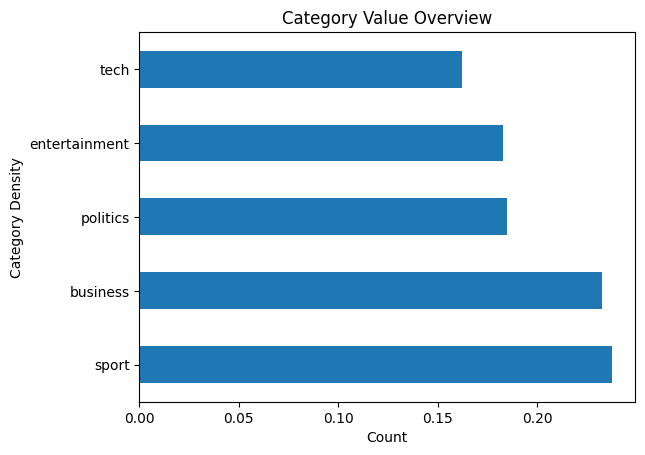

In [8]:
train = train.drop_duplicates(subset=['Category', 'Text'], keep='first')
print(train.shape)
column_breakdown(train,'Category')

Cool - that's better. Now we have slightly fewer tech articles, but the rest of the distribution of article categories is mostly the same. Now let's look and make sure we don't have any articles with empty/null text.

In [9]:
# Check for null values
null_values = train.isnull().sum()
print(f'Null Count:  \n{null_values}')

Null Count:  
ArticleId    0
Text         0
Category     0
dtype: int64


Good news, no empty texts here so no need to drop any additional rows. 

### Text Analysis

For the next part of the analysis, we'll want to take a look at the text that we're working with. I'm going to start by looking at word counts - it may be more difficult to classify articles if some articles have fewer words to work with.

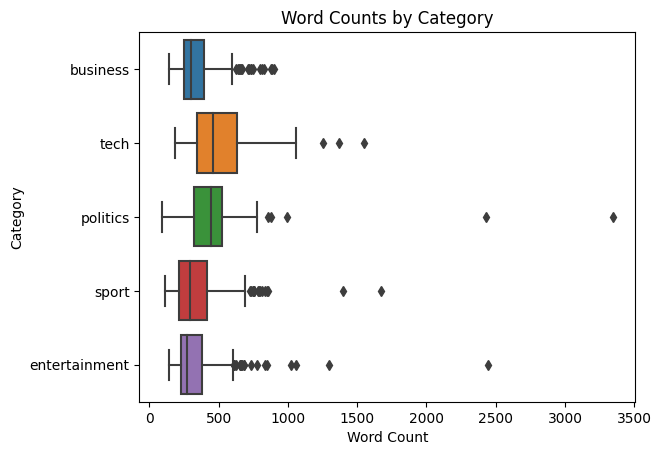

In [10]:
# Lets look at the Word Counts: 
train['word_count'] = train['Text'].apply(lambda x: len(x.split())) 

# Set up box plot
sns.boxplot(x='word_count', y='Category', data=train)
plt.xlabel('Word Count')
plt.ylabel('Category')
plt.title('Word Counts by Category')
plt.show()

In [11]:
grouped = train.groupby('Category')['word_count']
summary_stats = grouped.describe()
print(summary_stats)

               count        mean         std    min     25%    50%     75%  \
Category                                                                     
business       335.0  334.274627  133.713125  145.0  253.00  304.0  391.50   
entertainment  263.0  335.444867  207.134549  144.0  229.00  271.0  380.00   
politics       266.0  451.642857  261.490785   90.0  320.25  445.0  527.75   
sport          342.0  336.877193  185.930006  116.0  211.50  296.5  416.75   
tech           234.0  509.222222  212.922747  188.0  345.25  461.5  633.75   

                  max  
Category               
business        902.0  
entertainment  2448.0  
politics       3345.0  
sport          1671.0  
tech           1549.0  


These all look to be distributed mostly evenly again, so we don't need to worry about making changes to handle articles with smaller or larger word counts. Next, we can extracting word features and analyzing those. I'll be using the TF-IDF vectorizer here. In this section I'm going to see if we can get an idea of which words are used most commonly. 

Top Words: the, to, of, in, and, for, is, that, it, he


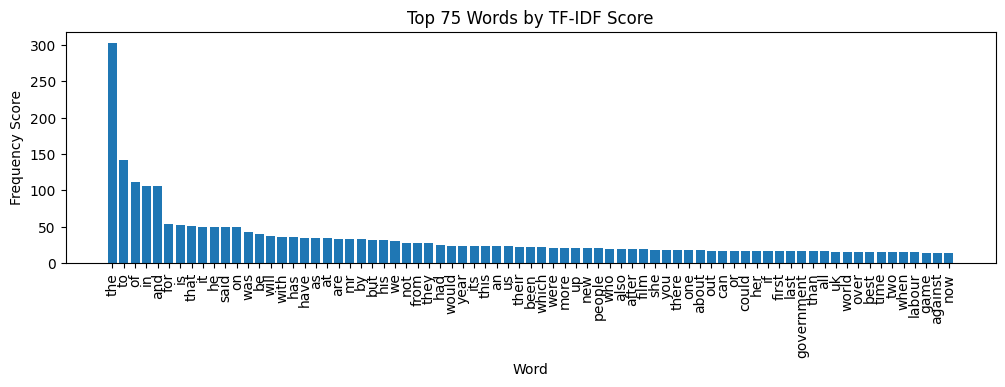

Top Words: the, to, of, in, and, for, is, said, on, it


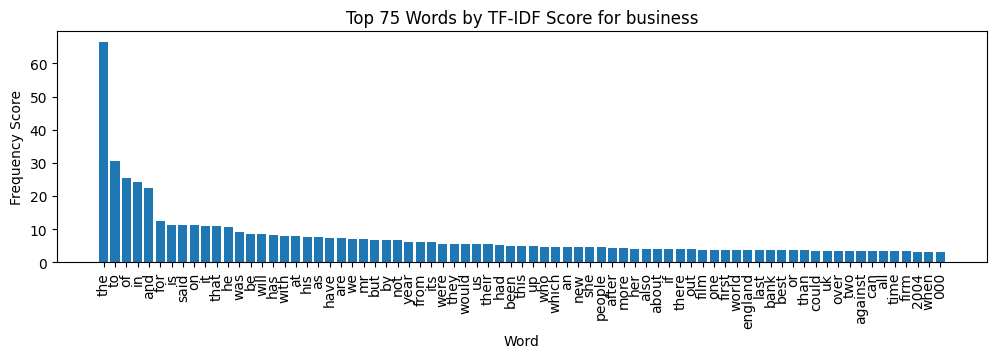

Top Words: the, to, of, and, in, is, for, on, it, that


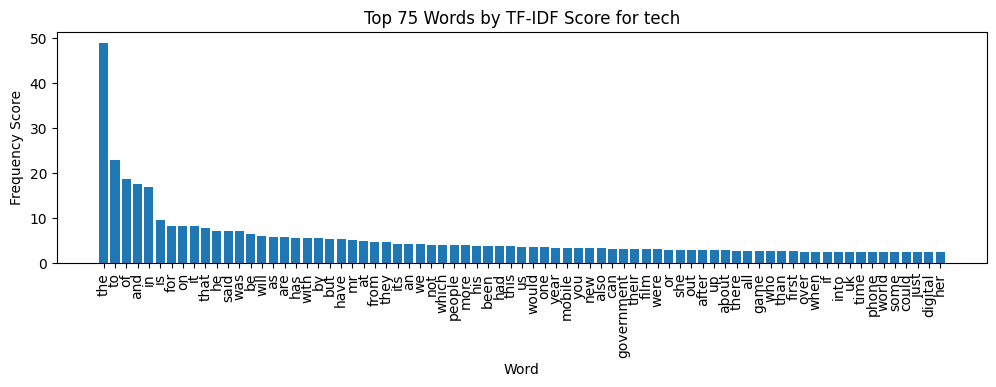

Top Words: the, to, of, and, in, for, he, that, on, said


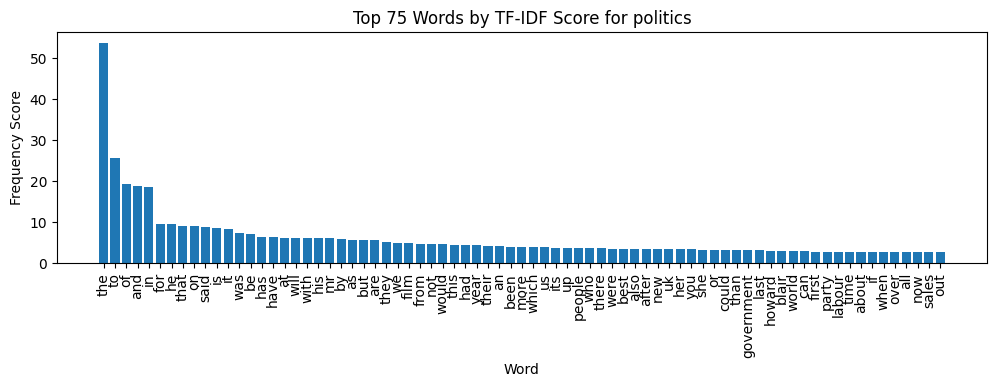

Top Words: the, to, of, in, and, said, is, for, he, it


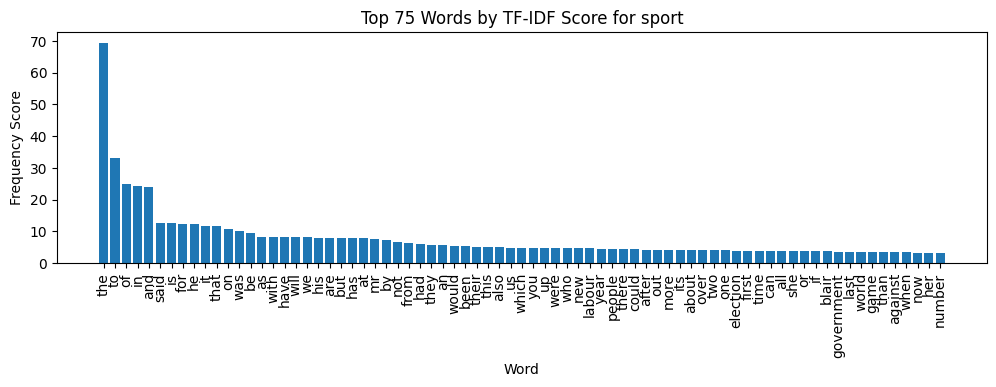

Top Words: the, to, and, of, in, that, for, it, is, on


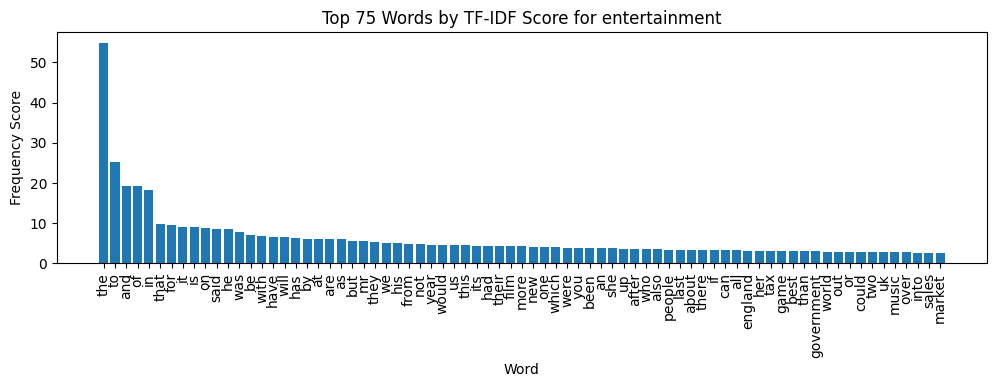

In [12]:
def show_top_words(vectorizer: TfidfVectorizer, tfidf_matrix: csr_matrix, words_to_show: int = 75, category: Optional[str] = None ) -> None:
    sum_scores = tfidf_matrix.sum(axis=0) # sum values across docs
    feature_names = vectorizer.get_feature_names_out()

    word_freq_df = pd.DataFrame(sum_scores.T, index=feature_names, columns=['tfidf_score'])

    # Sort to get most common words
    word_freq_df = word_freq_df.sort_values(by='tfidf_score', ascending=False)
    frequent_words_list = word_freq_df.index.tolist()[0:10]
    print(f'Top Words: {", ".join(frequent_words_list)}')
    plt.figure(figsize=(12, 3))
    plt.bar(word_freq_df.index[:words_to_show], word_freq_df['tfidf_score'][:words_to_show])
    plt.xlabel('Word')
    plt.ylabel('Frequency Score')
    if category:
        plt.title(f'Top {words_to_show} Words by TF-IDF Score for {category}')
    else:
        plt.title(f'Top {words_to_show} Words by TF-IDF Score')
    plt.xticks(rotation=90)  
    plt.show()
    
    
def show_top_words_by_category(vectorizer: TfidfVectorizer, tfidf_matrix: csr_matrix, data: pd.DataFrame) -> None:
    categories = data['Category'].unique()
    for category in categories:
        category_indices = data[data['Category'] == category].index
        category_indices = category_indices[category_indices < tfidf_matrix.shape[0]]
        category_tfidf = tfidf_matrix[category_indices]
        show_top_words(vectorizer, category_tfidf, category=category)

# Start by setting up a basic Vectorizer:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(train['Text'])

show_top_words(vectorizer, tfidf_matrix)
show_top_words_by_category(vectorizer, tfidf_matrix, data=train)



From the above outputs we can see that most of these words are common words that are likely to be found spread through the articles. But TF-IDF actually has a way to remove those common words so let's take a look without them.

Top Words: said, mr, year, new, people, world, film, england, best, bank


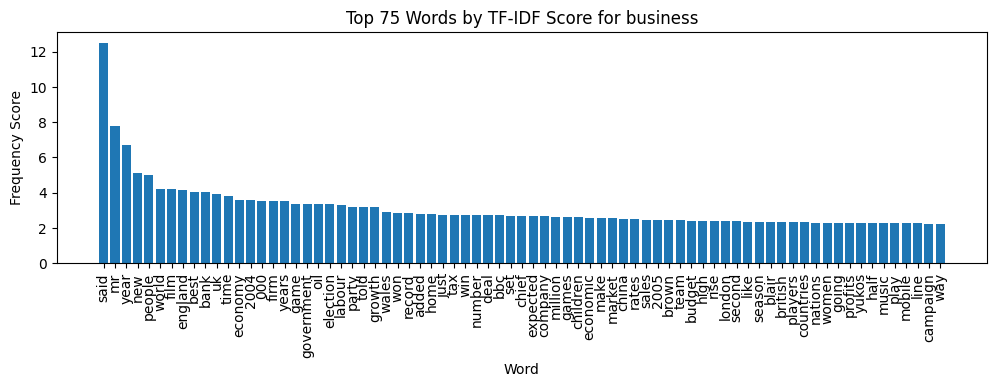

Top Words: said, mr, people, year, mobile, new, government, film, game, time


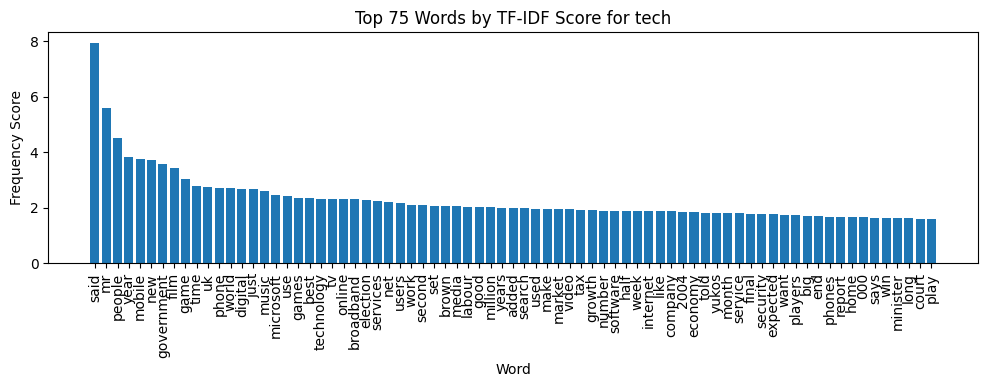

Top Words: said, mr, film, year, people, new, best, uk, government, howard


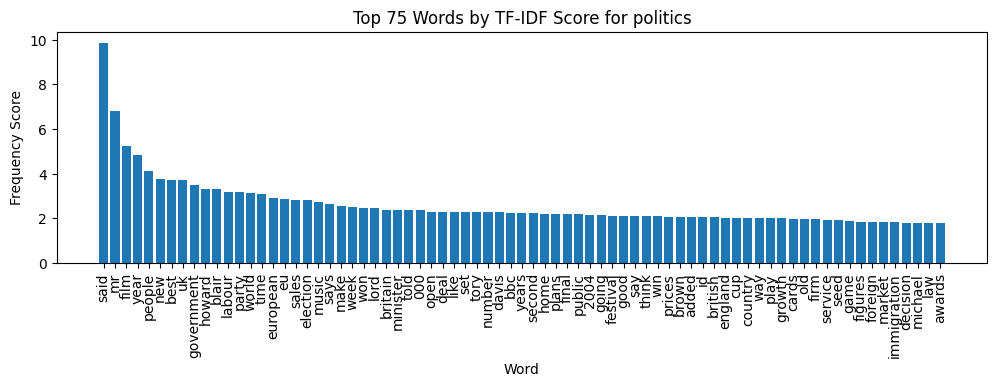

Top Words: said, mr, labour, new, year, people, election, time, blair, government


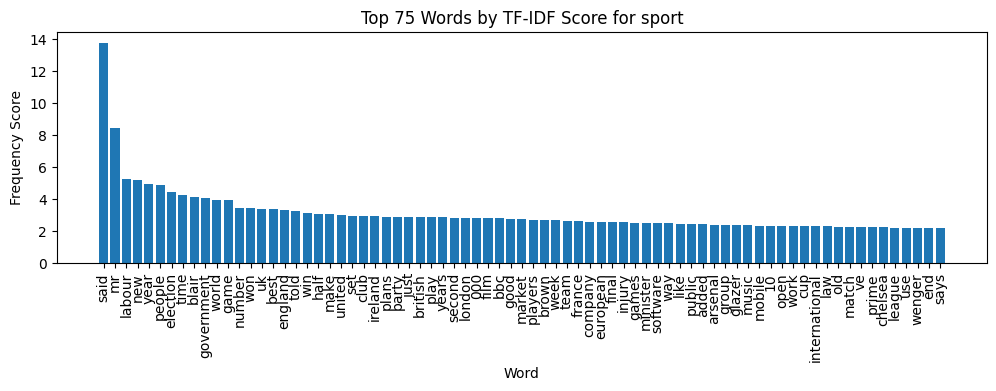

Top Words: said, mr, year, film, new, people, england, tax, game, government


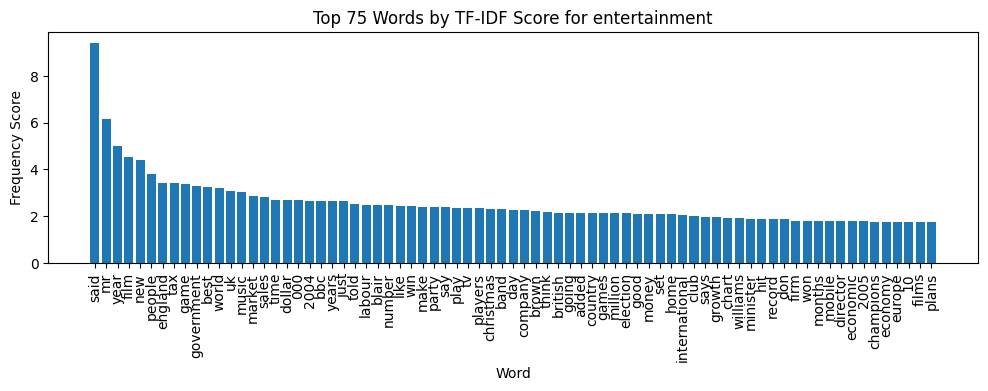

In [13]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(train['Text'])

show_top_words_by_category(vectorizer, tfidf_matrix, data=train)


Adding stop words seems to weed out many of the common words, but there are still some common words - we can adjust the stop words when we get to model tuning. 

# Step 2: Unsupervised Model Building

## Building the Model

In this step I'll start building and training with the unsupervised model. To build this model I'll be making use of the TF-IDF vectorizer and be using the NMF library to perform matrix vectorization. I'll start with a basic model, with no specific hyperparameter settings fir the vectorizer or the NMF model.

Sparsity of TF-IDF matrix: 0.9918923484828075
Optimal Labels found: {0: 'business', 4: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment'}
Accuracy: 0.8736111111111111


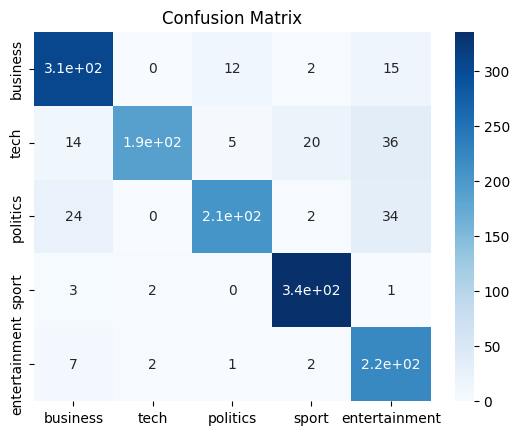

In [14]:
from typing import Dict, Any
class NmfModel():
    def __init__(self, training_df: pd.DataFrame, vector_args: Dict[str, Any] = {}, model_args: Dict[str, Any] = {}, show_conf_mat: bool = False, verbose: bool = False) -> None: 
        # Initialize + Fit model data:
        self.train = training_df
        self.y = self.train['Category']
        self.labels = self.y.unique()
        self.num_topics = len(self.labels)
        self.accuracy = None
        self.verbose = verbose
        
        # build the vectorizer + initialize nmf model 
        self.vectorizer = TfidfVectorizer(**vector_args)
        self.tfidf_matrix = self.vectorizer.fit_transform(self.train['Text'])

        if self.verbose:
            sparsity = 1.0 - self.tfidf_matrix.nnz / (self.tfidf_matrix.shape[0] * self.tfidf_matrix.shape[1])
            print(f"Sparsity of TF-IDF matrix: {sparsity}")
        
        # Apply NMF for matrix factorization
        self.model = NMF(n_components=self.num_topics, **model_args)
        
        # Fit + get predictions
        self.yhat = self.fit()
        self.evaluate(show_conf_mat=show_conf_mat)
    
    def label_permute_compare(self, y: np.ndarray, yhat: np.ndarray):
        """
        y: original labels from training data
        yhat: label predictions from model output
        We need to map the labels given by NMF output to the categories we've got in hand
        We can permute through the results and see which gives highest accuracy.
        Example output: (3, 4, 1, 2, 0), 0.74 
        """
        # get label values + create list of possible permutations
        label_permutations = list(itertools.permutations(range(len(self.labels))))
        best_label = None
        best_accuracy = 0
        for permutation in label_permutations: 
            # Map permutation to real label values
            label_map = {permutation[i]: label for i, label in enumerate(self.labels)}
            # Map yp to use permuted labels
            yhat_new = [label_map[value] for  value in yhat]
            accuracy = accuracy_score(y, yhat_new)
            # Update if accuracy is better
            if accuracy > best_accuracy: 
                best_accuracy = accuracy
                best_label = permutation 
        return best_label, best_accuracy
    
    def fit(self) -> np.ndarray:
        nmf_features = self.model.fit_transform(self.tfidf_matrix)
        # From NMF output we get a probability prediction for each possible category we want to choose the highest
        return np.argmax(nmf_features, axis=1)

    def evaluate(self, show_conf_mat: bool) -> None:
        labelorder, accuracy = self.label_permute_compare(self.train['Category'], self.yhat)
        self.accuracy = accuracy
        # Map values from numerical to Category values:
        label_map = {labelorder[i]: label for i, label in enumerate(self.labels)}
        if self.verbose: 
            print(f"Optimal Labels found: {label_map}\nAccuracy: {accuracy}")
        yhat_mapped = [label_map[value] for  value in self.yhat]
        # create confusion matrix from results
        if show_conf_mat: 
            conf_matrix = confusion_matrix(self.train['Category'], yhat_mapped)
            sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=self.labels, yticklabels=self.labels)
            plt.title("Confusion Matrix")
    
model = NmfModel(training_df=train, show_conf_mat=True, verbose = True)

THe initial results are about 87% accuracy, which isn't awful but with model tuning I think we can get this higher.

## Model Tuning

There are two parts to the model tuning, the vectorizer (how we are processing the words) and the NMF model itself. I'll start by looking at the vectorizer. As we saw in the EDA, the vectorizer can take stop words and exclude them. So we'll start by adding that:

Sparsity of TF-IDF matrix: 0.9941247092283648
Optimal Labels found: {4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}
Accuracy: 0.9083333333333333


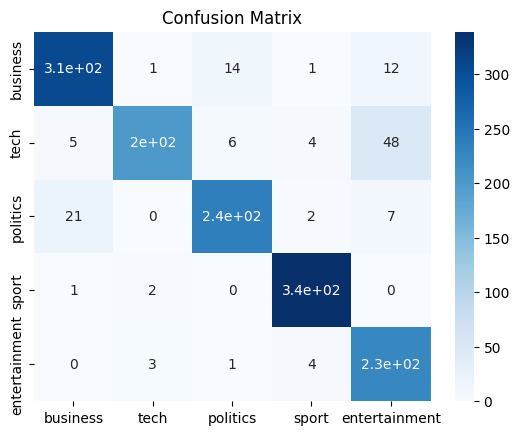

In [15]:
vector_args = {
    'stop_words': 'english'
}

NmfModel(training_df=train, vector_args = vector_args, show_conf_mat=True, verbose = True)

Just by removing common words from the equation, we see a bump in accuracy to about 91%. This is a good start. We may be able to tune these more. From the EDA we performed before, I'm going to add a few more words that appeared to be common across labels.


Sparsity of TF-IDF matrix: 0.9942293512837992
Optimal Labels found: {4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}
Accuracy: 0.9236111111111112


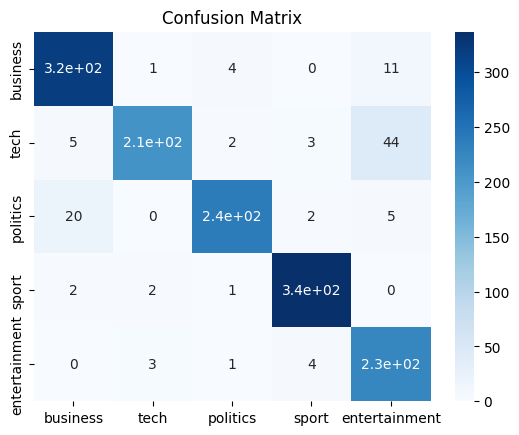

In [16]:

additional_stop_words = ['said', 'mr', 'year', 'new', '2004', '000']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)
vector_args = {
    'stop_words': list(stop_words),
}

model = NmfModel(training_df=train, vector_args = vector_args, show_conf_mat=True, verbose = True)

Awesome, by adding a few more we get up to 92% accuracy. 

Mext lets tunr the NMF model itself. There are a handful of parameters we can tune, all outlined in the documentation, [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html). In the next section I'm going to programatically test a handful of different parameters and see if I can get an idea of which tend to give us the highest accuracy and from there we can see if they make sense. I'll define a set of `model_args` and then have my code programaticaly create permutations of these arguments so we can test multiple sets of args at once. I'll be recording the time and the accuracy. This section may take a few minutes to run:

In [17]:
# Ignore convergence warnings 
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def test_hyperparameters(model_args, vector_args):
    # merge args passed in: 
    all_args = [dict(zip(model_args.keys(), values)) for values in itertools.product(*model_args.values())]
    print(len(all_args))
    
    hyperparam_results = pd.DataFrame(columns=list(model_args.keys())+['accuracy', 'time'])
    for i, args in enumerate(all_args):
        if (args['beta_loss'] != 'frobenius' and args['solver'] == 'cd') or (args['solver'] == 'mu' and args['init']=='nndsvd'): 
            continue
        try:
            start_time = time.perf_counter()
            model = NmfModel(training_df=train,  vector_args = vector_args, model_args = args)
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            hyperparam_results.loc[len(hyperparam_results)] = {**args, 'accuracy': model.accuracy, 'time': elapsed_time}
        except ValueError as e: 
            continue
    return hyperparam_results

In [18]:
model_args = {
    'solver': ['cd', 'mu'], 
    'init': [None, 'random', 'nndsvd', 'nndsvda', 'nndsvdar'], 
    'beta_loss': ['frobenius', 'itakura-saito', 'kullback-leibler'],
    'alpha_W': [0.1, 0.01, 0.001, 0.0001],
}

first_pass_results = test_hyperparameters(model_args, vector_args)
display(first_pass_results)

120


,solver,init,beta_loss,alpha_W,accuracy,time
0,cd,None,frobenius,0.1000,0.237500,1.536244
1,cd,None,frobenius,0.0100,0.237500,1.493234
2,cd,None,frobenius,0.0010,0.237500,1.651373
3,cd,None,frobenius,0.0001,0.910417,1.613662
4,cd,random,frobenius,0.1000,0.237500,1.276582
5,cd,random,frobenius,0.0100,0.237500,1.257727
6,cd,random,frobenius,0.0010,0.237500,1.415482
7,cd,random,frobenius,0.0001,0.910417,1.481702
8,cd,nndsvd,frobenius,0.1000,0.237500,1.535954
9,cd,nndsvd,frobenius,0.0100,0.237500,1.424084


OK now let's look at which gave us the best accuracy.

In [19]:
def show_high_accuracy_parms(results):
    highish_accuracy = (results['accuracy'] > .90).sum()
    print(f"Found {highish_accuracy}")
    good_results = results[results['accuracy'] > .90]
    good_results_sorted = good_results.sort_values(by='accuracy', ascending=False)

    display(good_results_sorted.head(highish_accuracy))
    
show_high_accuracy_parms(first_pass_results)

Found 21


,solver,init,beta_loss,alpha_W,accuracy,time
40,mu,nndsvda,kullback-leibler,0.1000,0.942361,5.512291
24,mu,None,kullback-leibler,0.1000,0.942361,6.324012
48,mu,nndsvdar,kullback-leibler,0.1000,0.940972,6.924018
49,mu,nndsvdar,kullback-leibler,0.0100,0.934722,6.366158
25,mu,None,kullback-leibler,0.0100,0.932639,6.359892
41,mu,nndsvda,kullback-leibler,0.0100,0.931944,5.572807
51,mu,nndsvdar,kullback-leibler,0.0001,0.931250,6.380986
50,mu,nndsvdar,kullback-leibler,0.0010,0.928472,6.371790
42,mu,nndsvda,kullback-leibler,0.0010,0.927083,5.742849
43,mu,nndsvda,kullback-leibler,0.0001,0.926389,5.594936


From the above it looks like we generally have good results when the solver is `mu` the beta loss function is `kullback-leibler` and for higher values of Alpha W. Lets tune this a little more to see if we can figure with Alpha and init values work best.

In [20]:
model_args = {
    'solver': ['mu'], 
    'init': [None, 'nndsvda', 'nndsvdar'],
    'beta_loss': ['kullback-leibler'],
    'alpha_W': np.arange(0.1, .5, 0.1),
}


second_pass_results = test_hyperparameters(model_args, vector_args)
show_high_accuracy_parms(second_pass_results)

12
Found 12


,solver,init,beta_loss,alpha_W,accuracy,time
2,mu,None,kullback-leibler,0.3,0.950000,6.588316
3,mu,None,kullback-leibler,0.4,0.950000,7.408973
7,mu,nndsvda,kullback-leibler,0.4,0.950000,8.232045
6,mu,nndsvda,kullback-leibler,0.3,0.949306,6.709308
10,mu,nndsvdar,kullback-leibler,0.3,0.946528,8.275119
5,mu,nndsvda,kullback-leibler,0.2,0.945833,6.624734
9,mu,nndsvdar,kullback-leibler,0.2,0.945833,9.232071
1,mu,None,kullback-leibler,0.2,0.945139,7.292071
11,mu,nndsvdar,kullback-leibler,0.4,0.944444,9.035089
0,mu,None,kullback-leibler,0.1,0.942361,5.664983


It looks like we've bumped it up to about 95% accuracy by tuning the NMF hyperparameters. Just for fun lets check and see if using just the stock stop_words changes anything.

Sparsity of TF-IDF matrix: 0.9941247092283648
Optimal Labels found: {4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}
Accuracy: 0.9534722222222223


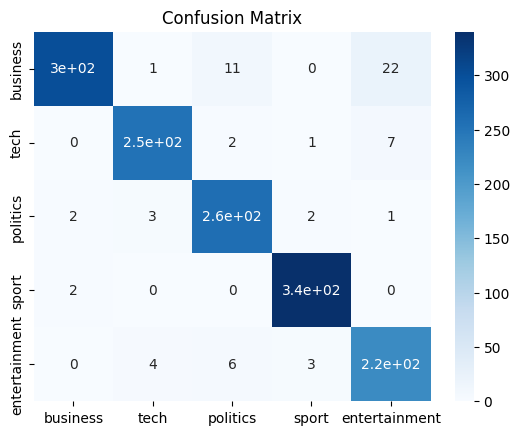

In [21]:
model_args = {
    'solver': 'mu', 
    'init': None,
    'beta_loss': 'kullback-leibler',
    'alpha_W': 0.4,
}
vector_args_simple = {
    'stop_words': 'english',
}
model = NmfModel(training_df=train, vector_args = vector_args_simple, model_args = model_args, show_conf_mat=True, verbose = True)

It looks like we get a little bump to just above 95%.

## Final Model

Sparsity of TF-IDF matrix: 0.9941247092283648
Optimal Labels found: {4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}
Accuracy: 0.9527777777777777


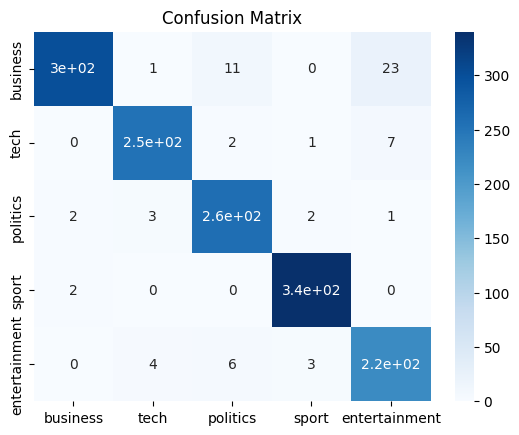

In [22]:
vector_args = {
    'stop_words': 'english',
}

model_args = {
    'solver': 'mu', 
    'init': None,
    'beta_loss': 'kullback-leibler',
    'alpha_W': 0.4,
}
model = NmfModel(training_df=train, vector_args = vector_args, model_args = model_args, show_conf_mat=True, verbose = True)

### Step 3: Supervised Model Comparison

Now that we've completed the unsupervised model. Let's try a supervised approach and see what we get.

In [23]:
def run_KNN(X, y, test_size: int = 0.2, show_conf_mat: bool = False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 555)

    k = len(train['Category'].unique())
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
        
    if show_conf_mat:
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, cmap="Blues")
        plt.title("Confusion Matrix")

    return accuracy_score(y_test, y_pred)
    

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train['Text'])
y = train['Category']

test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
x_axis = range(0,len(test_sizes))
accuracy = []
for size in test_sizes: 
    accuracy.append(run_KNN(X, y, size))

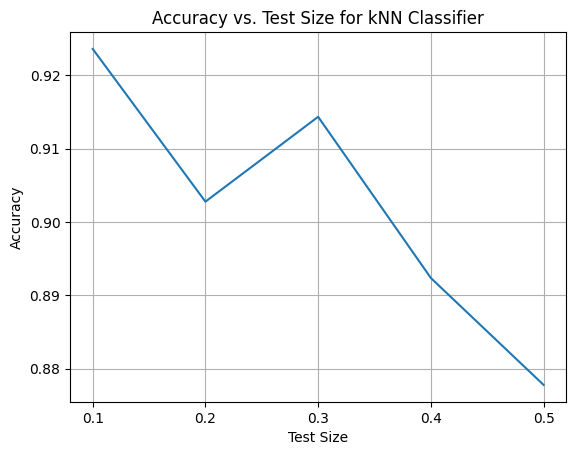

In [25]:
plt.plot(test_sizes, accuracy)
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Test Size for kNN Classifier')
plt.xticks(test_sizes)
plt.grid(True)
plt.show()

0.9027777777777778

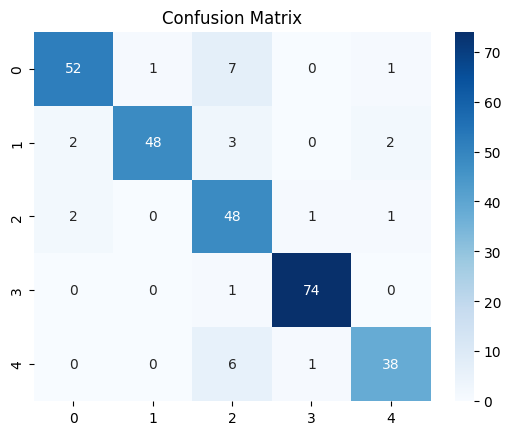

In [26]:
run_KNN(X, y, show_conf_mat = True)

In general we see that the supervised KNN model tends to perform slightly worse at about 90-92% compared to the unsupervised's 95%. We can also see that as we change the size of the training set we get different results as well. In general as we decrease the training size and increase the test size, the performance gets steadily worse. This makes sense because if you give less data to train off of your results won't be quite as stable. 